# Implementação de Máquinas de Vetores Suporte em Julia

   Este capítulo é dedicado a alguns experimentos númericos cujo objetivo é visualizar na prática a implementação da técnica das Máquinas de Vetores de Suporte (SVM), possibilitando assim analisar as particularidades da sua implementação juntamente com referencial teórico matemático desenvolvido no capítulo anterior. 
   
   Para desenvolvimento desses experimentos utilizaremos o *software* de programação Julia em sua versão 1.4.0, além dos pacotes ``Plots`` para gerar as imagens, ``JuMP`` e ``Ipopt`` para resolução dos problemas de otimização, ``RDatasets`` para ter acesso ao conjunto de dados Iris e o pacote ``DataFrame`` para gerar algumas tabelas de dados.
   
   Como abordado anteriormente, Máquinas de Vetores de Suporte é um algoritmo de Aprendizagem de Máquina muito utilizado para classificação e regressão, e nosso objetivo será sua aplicação em problemas que envolvam a classificação de dados. Primeiramente vamos relembrar que em problemas de classificação estamos interessados, assim como o nome já antecipa, em classificar da melhor maneira possível um determinado conjunto de dados. No caso em que os dados são linearmente separáveis, isto é, existe um hiperplano que os separa corretamente, aplica-se a SVM de margem rígida e o problema costuma ter uma resolução mais simples. Entretanto, os problemas de classificação que envolvem situações reais costumam ser mais elaborados, pois neste caso os dados geralmente não são linearmente separáveis. Nestas situações é necessário utilizar a SVM com margem flexível (C-SVM), se os dados forem, a grosso modo, mais "comportados", ou a SVM não-linear. Este último caso exige um desenvolvimento teórico matemático mais avançado e que foge do escopo deste trabalho e portanto não será abordado, se constituindo numa proposta de estudos a ser desenvolvido em projetos futuros. 
   
   Neste primeiro momento nosso propósito será implementar o algoritmo de SVM num exemplo prático: o conjunto de dados flor Íris. Tal conjunto de dados consiste em 150 amostras de três espécies da planta Iris, sendo 50 amostras da Iris setosa, 50 da Iris virginica e 50 da Iris versicolor. Cada dado amostral contém as medidas de quatro variáveis morfológicas: comprimento e largura das sépalas e das pétalas, medidas em centímetros. É com base nas diferenciações e semelhanças dessas características que é possível distinguir uma espécie da outra. Tais dados foram introduzidos pelo estatístico e biólogo Ronald Fisher em um artigo seu de 1936, e *"através da combinação dessas quatro características ele desenvolveu um modelo discriminante linear para distinguir as espécies".* (informação retirada da wikipedia, fazer citação correta).

   O conjunto de dados Iris é um exemplo clássico utilizado para testes e estudo de técnicas de classificação em Aprendizagem de Máquina, como por exemplo as Máquinas de Vetores de Suporte. Além disso, este conjunto se constitui num bom exemplo para diferenciar técnicas supervisionadas de não-supervisionadas. Por exemplo, para implementar a técnica de SVM na classificação dos dados Iris será fundamental a informação da espécie a qual cada dado de treinamento pertence, de modo que a máquina consiga aprender detectando um padrão entre as características de cada amostra e a espécie a qual ela pertence de fato. Dessa forma o algoritmo irá criar uma função de decisão que permitirá classificar corretamente novos dados. Ou seja, sem a informação da espécie nos dados de treinamento não é possível aplicar tal técnica, e tal informação é coletada por um indivíduo, isto é, há uma supervisão humana. Enquanto que técnicas não-supervisionadas não necessitam que os dados sejam previamente rotulados.

In [134]:
using Pkg
pkg"add RDatasets"
pkg"add JuMP"
pkg"add Ipopt"
pkg"add Plots"
pkg"add StatsBase"
pkg"add DataFrames"
pkg"add CSV"

  Resolving package versions...
   Updating `C:\Users\paula\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\paula\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `C:\Users\paula\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\paula\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `C:\Users\paula\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\paula\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `C:\Users\paula\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\paula\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versions...
   Updating `C:\Users\paula\.julia\environments\v1.4\Project.toml`
 [no changes]
   Updating `C:\Users\paula\.julia\environments\v1.4\Manifest.toml`
 [no changes]
  Resolving package versi

In [135]:
using RDatasets, JuMP, Ipopt, Random, LinearAlgebra, Plots, StatsBase, DataFrames, CSV

   Primeiramente, vamos importar o conjunto de dados Iris. Perceba que as amostras pertencem a três diferentes espécies: Iris setosa, Iris versicolor e Iris virginica. Nosso objetivo aqui será aprender a separar a espécie setosa das demais.

In [66]:
iris = dataset("datasets", "iris")
levels(iris[!,:Species])

3-element Array{String,1}:
 "setosa"
 "versicolor"
 "virginica"

   Pretendemos inicialmente trabalhar com o problema que compreende apenas duas características. O cojunto de dados será representado por uma matriz  $X^{p\times n}$, e que $p$ indica a quantidade de dados e $n$ o número de características (atributos) coletados em cada amostra. O vetor $Y$ por sua vez contém a representação numérica da espécie a qual cada dado pertence, isto é, cada dado é classificado como $1$ se pertence a espécie setosa e $-1$ caso pertença a espécie versicolor ou virginica.

In [140]:
X = convert(Array,iris[:, 1:2]) 
p, n = size(X)

(150, 2)

In [147]:
# SVM format expects positive and negative examples to +1/-1
Y = [species == "setosa" ? 1.0 : -1.0 for species in iris[!,:Species]]

150-element Array{Float64,1}:
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  ⋮
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0

   Na tabela a seguir é possível vizualizar o conjunto de dados Iris com sua respectiva classificação e os valores de duas características especificados.

In [149]:
iris_df = DataFrame(X);

In [150]:
iris_df.Espécie = Y;

In [151]:
rename!(iris_df, Dict(:x1 => :"Comprimento sépala"))
rename!(iris_df, Dict(:x2 => :"Largura sépala"))

,Comprimento sépala,Largura sépala,Espécie
,Float64,Float64,Float64
1,5.1,3.5,1.0
2,4.9,3.0,1.0
3,4.7,3.2,1.0
4,4.6,3.1,1.0
5,5.0,3.6,1.0
6,5.4,3.9,1.0
7,4.6,3.4,1.0
8,5.0,3.4,1.0
9,4.4,2.9,1.0


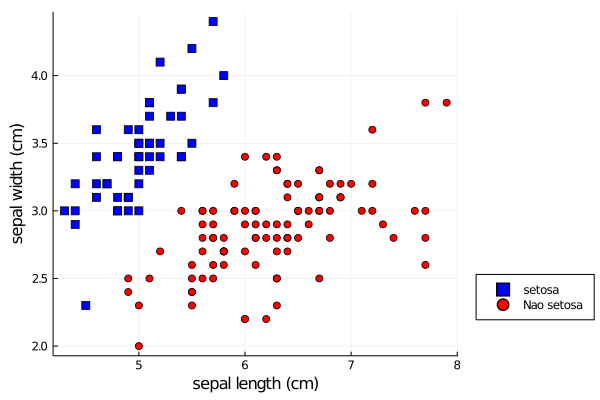

In [97]:
I = findall(Y .== 1)
scatter(X[I,1], X[I,2], c=:blue, m=:square, label = "setosa")
I = findall(Y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle, label = "Nao setosa", legend=:outerbottomright)
plot!(xlabel="sepal length (cm)", ylabel="sepal width (cm)")

   No gráfico acima temos representados os 150 pontos que correpondem aos nossos dados amostrais, em que os pontos em azul representam a espécie setosa, isto é, os vetores $x^{i}$ tais que $y_{i} = 1$, e os pontos em vermelho as espécies versicolor e virginica que correspondem aos vetores $x^{i}$ tais que $y_{i} = -1$. 

   Como abordado no capítulo anterior, a modelagem do problema de classificação utilizando a técnica de SVM consiste em determinar o hiperplano que melhor separa os dados, classificando-os assim em duas classes. Desse modo, analisando atentamente tal gráfico  pode-se intuir que é possível separar os dados através de um hiperplano. Neste caso, como os dados pertencem ao $\mathbb{R}^{2}$, o hiperplano será uma reta. 

   Ademais, como demonstrado no capítulo anterior, o hiperplano ótimo é aquele que maximiza a margem que não contenha nenhum dos dados. Logo, desejamos que os pontos $x^{i}$ satisfaçam a seguinte restrição

$$
y_i(w^{T}x^{i}+b) \geq 1, \quad i=1, \ldots , 150.
$$

Portanto, com base no que foi desenvolvido em capítulos anteriores, o problema de encontrar o hiperplano ótimo $\mathcal{H}(w,b)$ é formulado da seguinte forma

\begin{aligned}
\min_{w,b} & \quad \dfrac{1}{2} \Vert w\Vert^{2} \\
\text{s.a.} &  \quad y_i(w^{T}x^{i}+b) \geq 1, \quad i=1, \ldots , 150, 
\end{aligned}

em que, neste exemplo, $w \in \mathbb{R}^{2}$ e $b\in \mathbb{R}$. 

In [152]:
Random.seed!(0)
trainsize = 30 # Esta é a quantidade de dados que irá compor o conjunto de treinamento.
train_set = sample(1:p,trainsize,replace=false,ordered=true) # Lembre, p=150 é o número total de dados amostrais. Neste comando estamos pedindo para selecionar 30 dados aleatoriamente, e "replace" é para selecionar números diferentes.
test_set = setdiff(1:p,train_set) 
Xtrain = X[train_set,:]
Ytrain = Y[train_set]
Xtest = X[test_set,:]
Ytest = Y[test_set]
ptrain = length(Ytrain)

30

A seguir, utilizando o modelo matemático mencionado anteriormente e que foi formulado no capítulo anterior, vamos resolver o problema de classificação. 

In [153]:
model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

@variable(model, w[1:n]) # Aqui declaramos as variáveis.
@variable(model, b)

@objective(model, Min, dot(w, w) / 2) # Esta é a função objetivo.

@constraint(model, [i=1:ptrain], Ytrain[i] * (dot(w, Xtrain[i,:]) + b) ≥ 1) # Esta é a restrição.

# print(model) 
optimize!(model)

w, b = value.(w), value.(b) # Com este comando queremos que os valores ótimos sejam apresentados.

([-3.9999999608694576, 4.9999999508060435], 5.599999946154862)

Os valores apresentados acima correspondem aos valores ótimos encontrados para $w$ e $b$. Para melhor visualizar a classificação dos dados de treinamento vamos representá-los graficamente junto com o hiperplano ótimo.

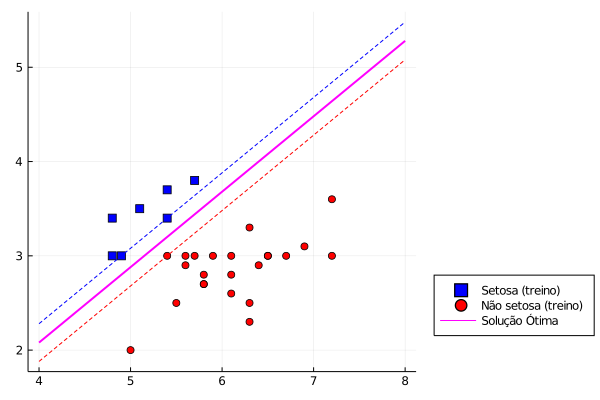

In [154]:
I = findall(Ytrain .== 1)
scatter(Xtrain[I,1], Xtrain[I,2], c=:blue, m=:square, label = "Setosa (treino)", legend=:outerbottomright)
I = findall(Ytrain .== -1)
scatter!(Xtrain[I,1], Xtrain[I,2], c=:red, m=:circle, label = "Não setosa (treino)")
# plot!(leg=false)
plot!(x -> -(w[1] * x + b) / w[2], 4, 8, c=:magenta, lw=:2,label = "Solução Ótima")
plot!(x -> -(w[1] * x + b - 1) / w[2], 4, 8, c=:blue, l=:dash,label = "")
plot!(x -> -(w[1] * x + b + 1) / w[2], 4, 8, c=:red, l=:dash,label = "")

Agora, vamos analisar se tal hiperplano também pe um bom classificador para o conjunto de dados de teste.

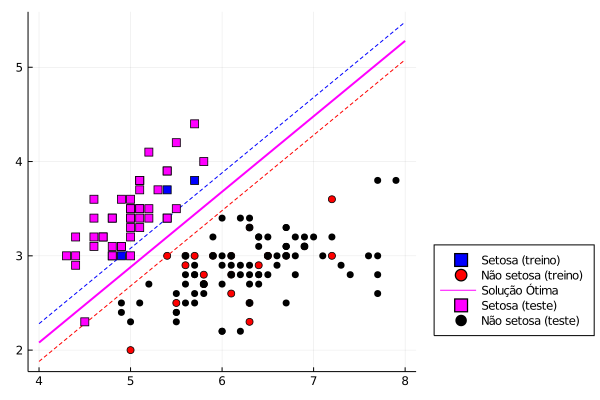

In [155]:
I = findall(Ytest .== 1)
scatter!(Xtest[I,1], Xtest[I,2], c=:magenta, m=:square, label = "Setosa (teste)", legend=:outerbottomright)
I = findall(Ytest .== -1)
scatter!(Xtest[I,1], Xtest[I,2], c=:black, m=:circle, label = "Não setosa (teste)")

Analisando o gráfico acima percebe-se que há um dado da espécie setosa que está localizado do lado incorreto do hiperplano, logo, o hiperplano definido não é o que melhor classifica os dados. Para verificar de modo mais eficiente se o classificador encontrado é o melhor, basta comparar rótulo correto dos dados de teste com a classificação definida pelo hiperplano encontrado.

In [102]:
Setosa = findall(Xtest*w .+ b .>= 0)
Nonsetosa = findall(Xtest*w .+ b .< 0)
@show all(Ytest[Setosa] .== 1)
@show all(Ytest[Nonsetosa] .== -1);

all(Ytest[Setosa] .== 1) = true
all(Ytest[Nonsetosa] .== -1) = false


## Implementação SVM - Margem Rígida

Iniciaremos analisando o caso de SVM com margem rígida. Nesta situação estaremos lidando com dados que são linearmente separáveis e para tanto geramos um conjunto de dados aleatórios que obedeçam a essa característica. Os dados a seguir foram gerados com o pacote ``Random``

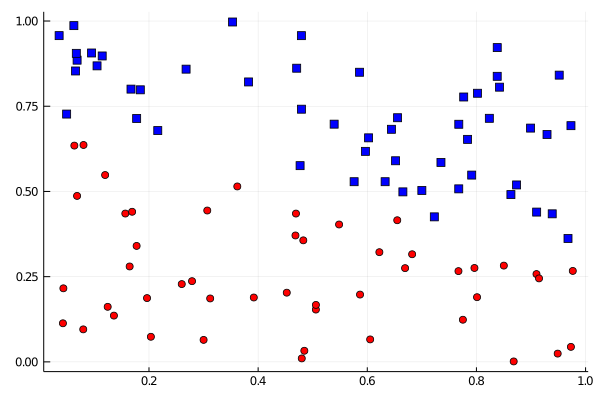

In [71]:
using Plots
gr(size=(600,400))
plot(rand(3),rand(3))
nothing

using Random, LinearAlgebra 

Random.seed!(0)

n = 100 #quantidade de dados
X = rand(n, 2)
w_0 = [0.3; 0.7] 
b_0 = -0.5
y = [dot(w_0, X[i,:]) + b_0 > 0 ? 1 : -1 for i = 1:n]

plot(leg=false)
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

Na imagem acima temos representados 100 pontos que correpondem aos nossos dados, em que os pontos em azul representam os vetores $x^{i}$ tais que $y_{i} = 1$ e os pontos em vermelho correspondem aos vetores $x^{i}$ tais que $y_{i} = -1$. Desse modo, o conjunto de dados é dado por 

$$
\Omega = \{ (x^1, y_1), \ldots , (x^{100}, y_{100})\mid x^i \in \mathbb{R}^{2} \, e \, y_i \in \{-1,1\} \} .
$$

A modelagem do problema de classificação utilizando a técnica de aprendizado SVM consiste em determinar o hiperplano que melhor separa os dados, o que acaba por classificá-los. Assim, o fato de os dados serem linearmente separáveis implica a existência de um hiperplano que os separa corretamente, tanto é que para obtermos os pontos agrupados como na figura acima informamos valores iniciais $w_{0}$ e $b_{0}$ para garantir que os dados fossem linearmente separáveis. No entanto, como veremos mais a frente, esses não serão os valores ótimos do problema. 

Um detalhe importante de se observar é que como os dados pertencem ao $\mathbb{R}^{2}$ o hiperplano será uma reta neste caso. Ademais, como demonstrado no capítulo anterior, o hiperplano ótimo é aquele que maximiza a margem que não contenha nenhum dos dados. Logo, desejamos que os pontos $x^{i}$ também satisfaçam as seguintes restrições 
$$
w^{T}x^{i} + b \geq 1 \quad \text{para} \quad y_{i} = 1
$$
e
$$
w^{T}x^{i} + b \leq -1 \quad \text{para} \quad y_{i} = -1,
$$
que podem ser compactadas da forma
$$
y_i(w^{T}x^{i}+b) \geq 1, \quad i=1, \ldots , 100.
$$

Portanto, com base no que foi desenvolvido em capítulos anteriores, o problema de encontrar o hiperplano ótimo $\mathcal{H}(w,b)$ é formulado da seguinte forma

\begin{aligned}
\min_{w,b} & \quad \dfrac{1}{2} \Vert w\Vert^{2} \\
\text{s.a.} &  \quad y_i(w^{T}x^{i}+b) \geq 1, \quad i=1, \ldots , 100, 
\end{aligned}

em que, neste exemplo, $w \in \mathbb{R}^{2}$ e $b\in \mathbb{R}$. 

Então, no intuito de solucionar o problema acima descrito utilizando os pacotes ``JuMP`` e ``Ipopt``, vamos primeiramente fazer a sua modelagem.

In [69]:
using JuMP, Ipopt

model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

@variable(model, w[1:2]) # Aqui declaramos as variáveis.
@variable(model, b)

@objective(model, Min, dot(w, w) / 2) # Esta é a função objetivo.

@constraint(model, [i=1:n], (dot(w, X[i,:]) + b) * y[i] ≥ 1) # Esta é a restrição.

print(model) 

Min 0.5 w[1]² + 0.5 w[2]²
Subject to
 0.8236475079774124 w[1] + 0.7145890517231919 w[2] + b >= 1.0
 0.9103565379264364 w[1] + 0.4394579359338935 w[2] + b >= 1.0
 -0.16456579813368521 w[1] - 0.27989925502310564 w[2] - b >= 1.0
 -0.17732884646626457 w[1] - 0.3401842212195725 w[2] - b >= 1.0
 -0.278880109331201 w[1] - 0.23679985501360878 w[2] - b >= 1.0
 -0.20347655804192266 w[1] - 0.07362716161818517 w[2] - b >= 1.0
 -0.042301665932029664 w[1] - 0.1132182900932166 w[2] - b >= 1.0
 0.06826925550564478 w[1] + 0.8851655573738955 w[2] + b >= 1.0
 -0.3618283907762174 w[1] - 0.5146689804348994 w[2] - b >= 1.0
 0.9732164043865108 w[1] + 0.692970759120777 w[2] + b >= 1.0
 0.5858115517433242 w[1] + 0.8497031958709513 w[2] + b >= 1.0
 0.5392892841426182 w[1] + 0.6974056124492531 w[2] + b >= 1.0
 -0.26003585026904785 w[1] - 0.22823146819255946 w[2] - b >= 1.0
 -0.910046541351011 w[1] - 0.2576252988200516 w[2] - b >= 1.0
 0.16703619444214968 w[1] + 0.8002161278923636 w[2] + b >= 1.0
 0.6554484126999

Com o comando ``print(model)`` obtemos a modelagem do nosso problema, em que as restrições são apresentadas de maneira detalhada. Como é possível observar ele está condizente com o nosso problema proposto originalmente.

Feito isso vamos resolver o problema de classificação.

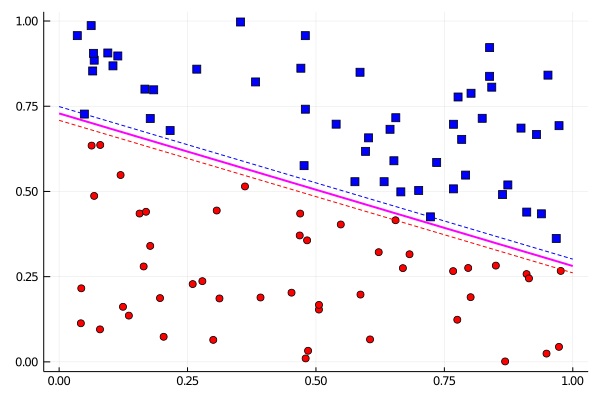

In [46]:
using JuMP, Ipopt

model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

@variable(model, w[1:2])
@variable(model, b)

@objective(model, Min, dot(w, w) / 2)

@constraint(model, [i=1:n], (dot(w, X[i,:]) + b) * y[i] ≥ 1)

optimize!(model)

w, b = value.(w), value.(b) #aqui queremos desenhar os valores ótimos

plot(leg=false)
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

plot!(x -> -(w[1] * x + b) / w[2], 0, 1, c=:magenta, lw=:2)
plot!(x -> -(w[1] * x + b - 1) / w[2], 0, 1, c=:blue, l=:dash)
plot!(x -> -(w[1] * x + b + 1) / w[2], 0, 1, c=:red, l=:dash)

Analisando a imagem acima temos representado o hiperplano ótimo que melhor classifica esses dados, assim como os hiperplanos da margem. Além disso, os valores ótimos para $w$ e $b$ são:

In [17]:
w, b

([22.1839900956983, 49.56328710292937], -36.12262702012526)

Note que tais valores são bem diferentes daqueles que estabelecemos para $w_{0}$ e $b_{0}$ inicialmente.

In [72]:
w_0, b_0

([0.3, 0.7], -0.5)

Por conseguinte, algumas observações podem ser feitas sobre a figura acima. Note que os vetores (dados) que estão sobre os hiperplanos da margem são os que se encontram no estado mais crítico e devido a isso são eles que de fato definem o hiperplano separador. Em outras palavras, tais vetores dão suporte ao hiperplano ótimo, de modo que todos os demais vetores poderiam ser descartados sem causar alteração. E temos assim de onde deriva o nome dessa técnica de aprendizagem de máquina supervisionada, Máquinas de Vetores Suporte.

No entanto, como mencionado anteriormente, em problemas que envolvam situações reais os dados não costumam ser linearmente separáveis e assim, não existe um hiperplano separador que classifica os dados corretamente. Em vista disso, vamos analisar o caso em que os dados apresentam uma margem flexível e desenvolver o problema de classificação com margem flexível (C-SVM).

$%Neste caso, se submetermos dados não-linearmente separáveis ao método anterior ele falha, pois nem todos os dados irão obedecer as restrições impostas a função objetivo. Para tanto, vamos desenvolver para o caso SVM de margem flexível.$

## CSVM - Margem flexível

Vamos considerar agora um conjunto de dados não-linearmente separáveis, mas digamos ligeiramente comportados, como os representados a seguir.

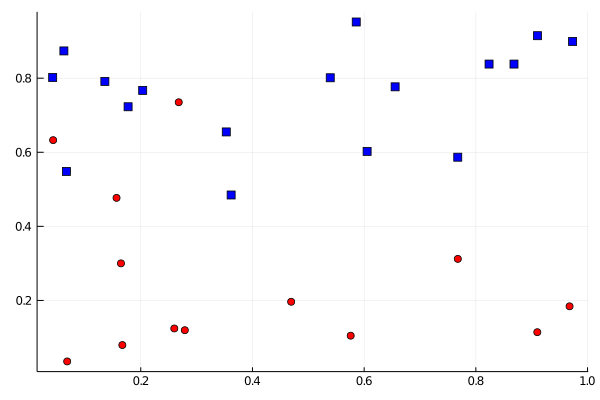

In [78]:
using Random, LinearAlgebra

Random.seed!(0)

n = 30 
X = rand(n, 2)
w_o = [0.3; 0.7]
b_o = -0.5
y = [dot(w_sol, X[i,:]) + b_sol > randn() * 0.1 ? 1 : -1 for i = 1:n] 

plot(leg=false)
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

Observando a figura acima percebe-se que não é possível traçar um hiperplano que separe os dados azuis dos vermelhos corretamente. Em decorrência disso, promovemos um relaxamento das restrições na tentativa de conseguir classificar corretamente os dados que não estejam no semiespaço correto. Tal relaxamento é feito acrescentando-se variáveis de folga $\xi_{i}$ às restrições.

No entanto, o ideal é que a maior quantidade de dados esteja localizado no semiespaço correto, isto é, que o maior número possível de variáveis de folga seja igual a zero. Em outras palavras, desejamos minimizar os valores das variáveis de folga. Para tanto, acrescentamos à nossa função objetivo do problema de classificação o somatório das variáveis $\xi_{i} \geq 0$ multiplicado por um parâmetro $C >0$. Tal parâmetro nada mais é do que uma penalização aos valores dos $\xi_{i}$.

Assim, de acordo com o desenvolvido em capítulos anteriores, podemos formular nosso problema da seguinte forma

\begin{aligned}
\min_{w,b, \xi} & \quad \dfrac{1}{2} \Vert w\Vert^{2} + C\sum_{i=1}^{30} \xi_{i} \\
\text{s.a.} &  \quad y_i(w^{T}x^{i}+b) \geq 1 - \xi_{i} , \quad i=1, \ldots , 30, \\
& \quad \xi_{i} \geq 0 , \quad i=1, \ldots , 30. 
\end{aligned}

em que $w \in \mathbb{R}^{2}$, $b\in \mathbb{R}$ e $C >0$. 

Primeiramente, vamos experimentar resolver esse problema com o mesmo modelo utilizado para resolver o caso anterior com margem rígida.

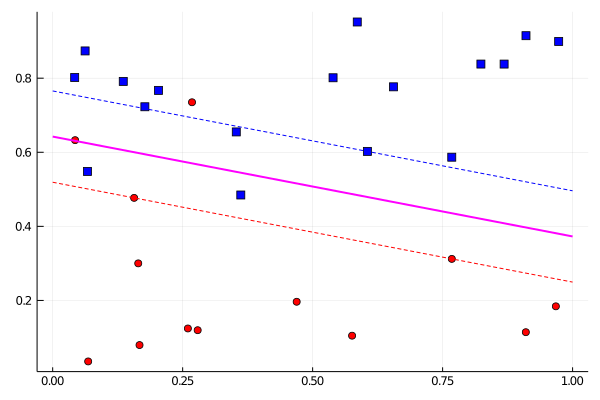

In [79]:
using JuMP, Ipopt

model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)) 

@variable(model, w[1:2])
@variable(model, b)

@objective(model, Min, dot(w, w) / 2)

@constraint(model, [i=1:n], (dot(w, X[i,:]) + b) * y[i] ≥ 1)

optimize!(model)

w, b = value.(w), value.(b)

plot(leg=false)
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

plot!(x -> -(w[1] * x + b) / w[2], 0, 1, c=:magenta, lw=:2)
plot!(x -> -(w[1] * x + b - 1) / w[2], 0, 1, c=:blue, l=:dash)
plot!(x -> -(w[1] * x + b + 1) / w[2], 0, 1, c=:red, l=:dash)

Perceba que o programa apresentou uma solução, entretanto, ao solicitarmos como ele encontrou essa solução obtemos a seguinte mensagem:

In [26]:
termination_status(model)

LOCALLY_INFEASIBLE::TerminationStatusCode = 5

Ou seja, não foi possível de resolver tal problema com a mesma formatação utilizada para o caso em que os dados são linearmente separáveis, e a solução apresentada suspeitamos que seja a mais próxima do que viria a ser uma solução ótima.

É em vista disso que se faz importante alteral o modelo utilizado anteriormente e acrescentar as variáveis de folga às restrições e à função objetivo. Vejamos como fazer isso na prática.

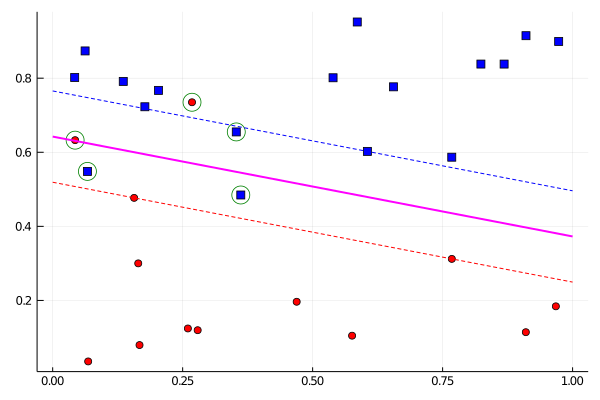

In [82]:
using JuMP, Ipopt

C = 100.0 # Quanto maior o valor deste parâmetro, maior será a penalização. 

model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

@variable(model, w[1:2])
@variable(model, b)
@variable(model, ξ[1:n] ≥ 0)

@objective(model, Min, dot(w, w) / 2 + C * sum(ξ))

@constraint(model, [i=1:n], (dot(w, X[i,:]) + b) * y[i] ≥ 1 - ξ[i])

optimize!(model)

w, b, ξ = value.(w), value.(b), value.(ξ)

plot(leg=false)
I = findall(ξ .> 1e-6) 
scatter!(X[I,1], X[I,2], c=:green, m=(:white, stroke(1,:green), 10))
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

plot!(x -> -(w[1] * x + b) / w[2], 0, 1, c=:magenta, lw=:2)
plot!(x -> -(w[1] * x + b - 1) / w[2], 0, 1, c=:blue, l=:dash)
plot!(x -> -(w[1] * x + b + 1) / w[2], 0, 1, c=:red, l=:dash)

Na figura acima temos representada a solução do problema utilizando SVM com margem flexível. 

Os vetores $x^{i}$ circulados em verde são aqueles que receberam folga, isto é, $\xi_{i} >0$. E ao analisar o que ocorre com esses vetores conforme alteramos os valores para o parâmetro $C$, nota-se que caso o valor atribuído a $C$ seja pequeno mais vetores recebem folga, inclusive alguns para os quais não seria necessário. Caso contrário, se valores muito altos são atribuídos ao parâmetro $C$, o número de vetores que recebem folga diminui. Contudo, neste último caso o programa tende a se concentrar em minimizar a penalização em vez da margem na função objetivo. Devido a isso, é de suma importância escolher o valor correto para o parâmetro $C$.
$% pesquisar de que forma esse parâmetro é determinado.$

Vejamos agora um caso com os dados dispostos de maneira um pouco mais "embaralhada".

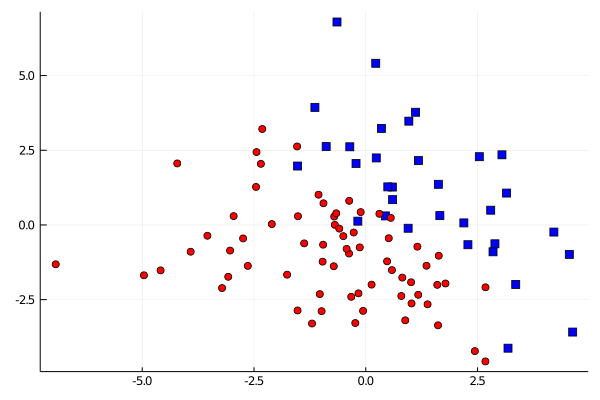

In [84]:
using Random, LinearAlgebra

Random.seed!(0)

n = 100 #quantidade de dados
X = randn(n, 2) * 2
w_sol = [0.5; 0.4]
b_sol = -0.5
y = [dot(w_sol, X[i,:]) + b_sol > randn() * 0.5 ? 1 : -1 for i = 1:n] # Aqui alteramos de 1.0 para 0.5 para tornar os dados não separáveis.

plot(leg=false)
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

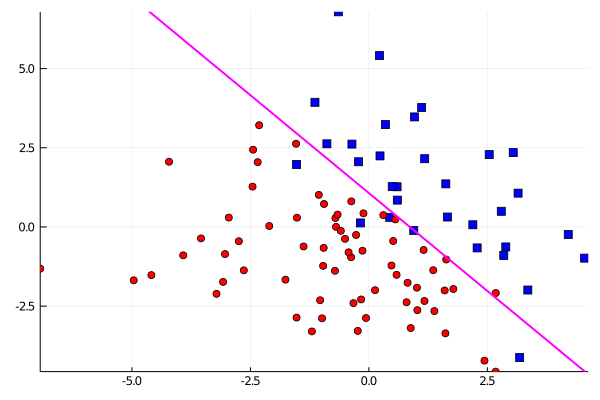

In [85]:
using JuMP, Ipopt

model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)) 

@variable(model, w[1:2])
@variable(model, b)

@objective(model, Min, dot(w, w) / 2)

@constraint(model, [i=1:n], (dot(w, X[i,:]) + b) * y[i] ≥ 1)

optimize!(model)

w, b = value.(w), value.(b)

plot(leg=false)
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

plot!(x -> -(w[1] * x + b) / w[2], extrema(X[:,1]) ..., c=:magenta, lw=:2)
xlims!(extrema(X[:,1])...)
ylims!(extrema(X[:,2])...)   

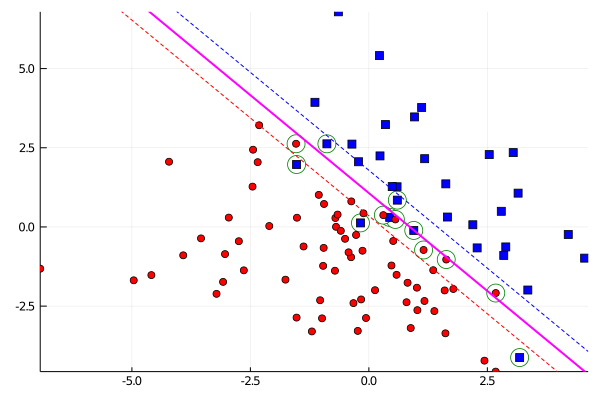

In [57]:
using JuMP, Ipopt

C = 100.0 

model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)) 

@variable(model, w[1:2])
@variable(model, b)
@variable(model, ξ[1:n] ≥ 0)

@objective(model, Min, dot(w, w) / 2 + C * sum(ξ))

@constraint(model, [i=1:n], (dot(w, X[i,:]) + b) * y[i] ≥ 1 - ξ[i])

optimize!(model)

w, b, ξ = value.(w), value.(b), value.(ξ)

plot(leg=false)
I = findall(ξ .> 1e-6) 
scatter!(X[I,1], X[I,2], c=:green, m=(:white, stroke(1,:green), 10))
I = findall(y .== 1)
scatter!(X[I,1], X[I,2], c=:blue, m=:square)
I = findall(y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle)

plot!(x -> -(w[1] * x + b) / w[2], extrema(X[:,1]) ..., c=:magenta, lw=:2)
plot!(x -> -(w[1] * x + b - 1) / w[2], extrema(X[:,1]) ..., c=:blue, l=:dash)
plot!(x -> -(w[1] * x + b + 1) / w[2], extrema(X[:,1]) ..., c=:red, l=:dash)
xlims!(extrema(X[:,1])...)
ylims!(extrema(X[:,2])...) 

Neste último exemplo, o problema possui $2 + 1 + n$ variáveis e $n$ restrições. Assim, na prática esses valores podem assumir valores muito altos, o que pode tornar sua resolução bem trabalhosa.

## Implementação de SVM no Dataset Iris

Como abordado anteriormente, Máquinas de Vetores de Suporte (SVM) é um algoritmo de Aprendizagem de Máquina muito utilizado para classificação e regressão, e nosso objetivo é sua aplicação para problemas que envolvam a classificação de dados. Em vista disso, neste momento nosso propósito será implementar o algoritmo de SVM num exemplo prático: o conjunto de dados flor Íris.

O conjunto de dados flor Iris consiste em 50 amostras de três espécies da planta Iris, Iris setosa, Iris virginica e Iris versicolor, totalizando 150 dados amostrais. De cada amostra foram medidas quatro variáveis morfológicas: comprimento e largura das sépalas e pétalas, em centímetros. É com base nas diferenciações e semelhanças dessas características que é possível distinguir uma espécie da outra. Tais dados foram introduzidos pelo estatístico e biólogo Ronald Fisher em um artigo seu de 1936, e através da combinação dessas quatro características ele desenvolveu um modelo discriminante linear para distinguir as espécies.

O conjunto de dados Iris se tornou um clássico exemplo de conjunto de dados utilizado para testes e estudo de técnicas de classificação em Aprendizagem de Máquina, como por exemplo as Máquinas de Vetores de Suporte. Além disso, o conjunto de dados Iris se constitui num bom exemplo para diferenciar técnicas supervisionadas e não-supervisionadas. Para implementar a técnica de SVM na classificação destes dados é fundamental a informação da espécie a qual cada dado de treinamento pertence, de modo que a máquina consiga aprender detectando um padrão entre as características de cada amostra e a espécie a qual ela pertence. É dessa forma que o algoritmo irá criar uma função de decisão que permitirá classificar de maneira correta novos dados posterioremente. Ou seja, sem a informação da espécie nos dados de treinamento não é possível aplicar tal técnica, e essa informação é coletada por um indivíduo, isto é, há uma supervisão humana. Enquanto que técnicas não-supervisionadas não necessitam deste tipo de surpervisão.

Antes de avançarmos é importante retomar alguns conceitos fundamentais para compreender o desenvolvimento da implementação do algoritmo de SVM: dados de treinamento e de teste. Os dados de treinamento são aqueles utilizados para treinar o modelo, isto é, na aprendizagem do algoritmo para encontrar a função que permitirá classificar novos dados. Já os dados de teste serão utilizados para analisar se o modelo está classificando os dados corretamente. Dentro desta perspectiva, dois outros conceitos são de profunda relevância: as características (do inglês "features") e os rótulos (do inglês "labels"). As características irão compor o vetor de cada dado amostral, e é através delas que o algoritmo irá trabalhar para diferenciar as espécies e obter a função de decisão. Já o rótulo nada mais é do que a correta classificação dos dados, sendo com base nesta informação que o algoritmo de fato aprende, detectando padrões entre as características de uma amostra e seu rótulo.

### Caso com 4 características

In [113]:
# SVM format expects observations in columns and features in rows
X = convert(Array,iris[:, 1:4]) # mudar de 2 para 4 para característivas
p, n = size(X)

(150, 4)

In [131]:
X;

In [133]:
# SVM format expects positive and negative examples to +1/-1
Y = [species == "setosa" ? 1.0 : -1.0 for species in iris[!,:Species]];

In [130]:
iris_df = DataFrame(X);

In [129]:
iris_df.Species = Y;

In [132]:
names(iris_df);

In [73]:
rename!(iris_df, Dict(:x1 => :"sepal length (cm)"))
rename!(iris_df, Dict(:x2 => :"sepal width (cm)"))
rename!(iris_df, Dict(:x3 => :"petal length (cm)"))
rename!(iris_df, Dict(:x4 => :"petal width (cm)"))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
,Float64,Float64,Float64,Float64,Float64
1,5.1,3.5,1.4,0.2,1.0
2,4.9,3.0,1.4,0.2,1.0
3,4.7,3.2,1.3,0.2,1.0
4,4.6,3.1,1.5,0.2,1.0
5,5.0,3.6,1.4,0.2,1.0
6,5.4,3.9,1.7,0.4,1.0
7,4.6,3.4,1.4,0.3,1.0
8,5.0,3.4,1.5,0.2,1.0
9,4.4,2.9,1.4,0.2,1.0


Na tabela acima, a primeira coluna apresenta uma numeração dos dados, as quatro colunas que vêm em seguida correspondem as diferentes características de cada dado amostral, e a última corresponde a espécie correta a qual o dado pertence, sendo classificada como 1 se é da espécie setosa e -1 caso contrário.

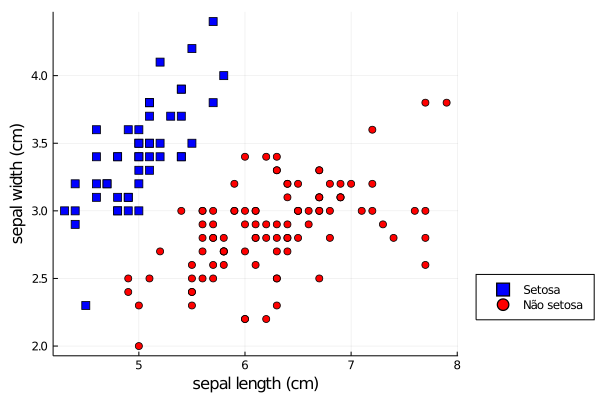

In [118]:
I = findall(Y .== 1)
scatter(X[I,1], X[I,2], c=:blue, m=:square, label = "Setosa")
I = findall(Y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle, label = "Não setosa", legend=:outerbottomright)
plot!(xlabel="sepal length (cm)", ylabel="sepal width (cm)")

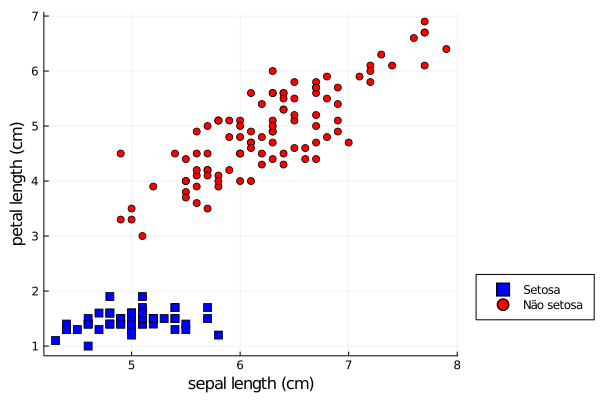

In [119]:
I = findall(Y .== 1)
scatter(X[I,1], X[I,3], c=:blue, m=:square, label = "Setosa")
I = findall(Y .== -1)
scatter!(X[I,1], X[I,3], c=:red, m=:circle, label = "Não setosa", legend=:outerbottomright)
plot!(xlabel="sepal length (cm)", ylabel="petal length (cm)")

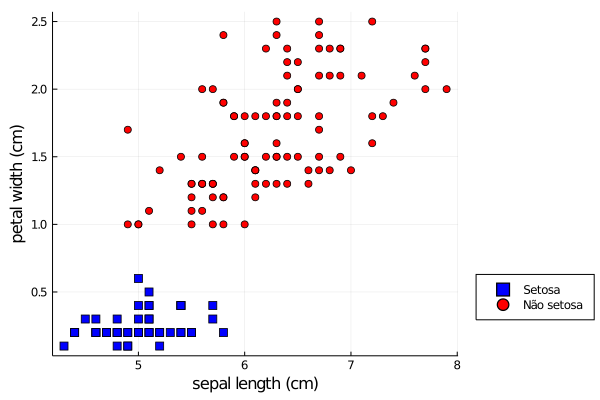

In [120]:
I = findall(Y .== 1)
scatter(X[I,1], X[I,4], c=:blue, m=:square, label = "Setosa")
I = findall(Y .== -1)
scatter!(X[I,1], X[I,4], c=:red, m=:circle, label = "Não setosa", legend=:outerbottomright)
plot!(xlabel="sepal length (cm)", ylabel="petal width (cm)")

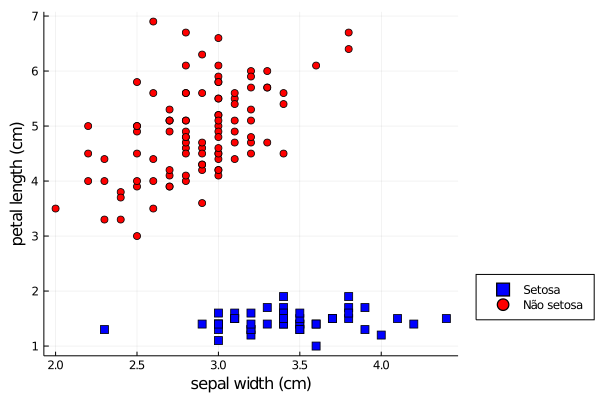

In [121]:
I = findall(Y .== 1)
scatter(X[I,2], X[I,3], c=:blue, m=:square, label = "Setosa")
I = findall(Y .== -1)
scatter!(X[I,2], X[I,3], c=:red, m=:circle, label = "Não setosa", legend=:outerbottomright)
plot!(xlabel="sepal width (cm)", ylabel="petal length (cm)")

Nos gráficos acima temos a representação dos dados amostrais de acordo com suas características, sendo que os dados em azul pertencem à espécie setosa e os dados em vermelho às espécies versicolor e virginica.

Analisando tais gráficos atentamente pode-se intuir que é possível separar os dados através de um hiperplano. É justamente na definição de um hiperplano ótimo que atua o algoritmo de SVM, lembrando que o hiperplano ótimo será aquele que maximiza a margem entre ele e os dados.

Assim, para construir o modelo do nosso problema vamos primeiramente dividir aleatoriamente os dados em dois conjuntos, o conjunto de treinamento, através do qual o algoritmo é treinado, e o conjunto de teste, que nos permite verificar posteriormente se o classificador encontrado é bom.

In [124]:
Random.seed!(0)
trainsize = 30 # Esta é a quantidade de dados que irá compor o conjunto de treinamento.
train_set = sample(1:p,trainsize,replace=false,ordered=true) # Lembre, p=150 é o número total de dados amostrais. Neste comando estamos pedindo para selecionar 30 dados aleatoriamente, e "replace" é para selecionar números diferentes.
test_set = setdiff(1:p,train_set) 
Xtrain = X[train_set,:]
Ytrain = Y[train_set]
Xtest = X[test_set,:]
Ytest = Y[test_set]
ptrain = length(Ytrain)

30

Tendo definido os conjuntos de treino e teste, vamos agora construir nosso modelo matemático utilizando a técnica de SVM.

In [125]:
model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

@variable(model, w[1:n]) # Aqui declaramos as variáveis.
@variable(model, b)

@objective(model, Min, dot(w, w) / 2) # Esta é a função objetivo.

@constraint(model, [i=1:ptrain], Ytrain[i] * (dot(w, Xtrain[i,:]) + b) ≥ 1) # Esta é a restrição.

# print(model) 
optimize!(model)

w, b = value.(w), value.(b) # Com este comando queremos que os valores ótimos sejam apresentados.

([-0.23049982221726428, 0.36721475450118474, -0.6954627616094768, -0.40882369457746726], 2.2610129614615118)

obs.: para o problema com quatro características não é possível plotar o gráfico com o hiperplano.

Vamos agora avaliar se o classificador encontrado é bom, isto é, se ele separa os dados corretamente. Para tanto, comparamos a classificação que os dados de teste obtiveram com a sua classsificação correta.

In [128]:
Setosa = findall(Xtest*w .+ b .>= 0)
Nonsetosa = findall(Xtest*w .+ b .< 0)
@show all(Ytest[Setosa] .== 1)
@show all(Ytest[Nonsetosa] .== -1);

all(Ytest[Setosa] .== 1) = true
all(Ytest[Nonsetosa] .== -1) = true


De fato, a classificação foi boa.